<a href="https://colab.research.google.com/github/vaishnavipatil29/NN_DL_Lab/blob/main/Spring_22_NNDL_Lab_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAB 9 : Transformers

Name : Joshitha, Vaishnavi

Roll Number : 

Preprocessing :   

1. PyTorch tutorial : https://github.com/yunjey/pytorch-tutorial
2. Tranformer : http://peterbloem.nl/blog/transformers
3. Text Preprocessing : https://www.analyticsvidhya.com/blog/2021/06/must-known-techniques-for-text-preprocessing-in-nlp/
4. More abou Self Attention : https://towardsdatascience.com/illustrated-self-attention-2d627e33b20a

#**Problem 1** : Building a Transformer

1. Build a Self Attention Block
2. Use the self attection block to build a transformer block

##Write down the Objectives, Hypothesis and Experimental description for the above problem


## Programming : 
  Please write a program to demonstrate the same

**Self Attention Block**

In [1]:
import torch
from torch import nn
import torch.nn.functional as F

class SelfAttention(nn.Module):
  def __init__(self, k, heads=8):
    super().__init__()
    self.k, self.heads = k, heads
    # These compute the queries, keys and values for all 
    # heads (as a single concatenated vector)
    self.tokeys    = nn.Linear(k, k * heads, bias=False)
    self.toqueries = nn.Linear(k, k * heads, bias=False)
    self.tovalues  = nn.Linear(k, k * heads, bias=False)

	# This unifies the outputs of the different heads into 
	# a single k-vector
    self.unifyheads = nn.Linear(heads * k, k)
   
  def forward(self, x):
    b, t, k = x.size()
    h = self.heads

    queries = self.toqueries(x).view(b, t, h, k)
    keys    = self.tokeys(x)   .view(b, t, h, k)
    values  = self.tovalues(x) .view(b, t, h, k)
    # - fold heads into the batch dimension
    keys = keys.transpose(1, 2).contiguous().view(b * h, t, k)
    queries = queries.transpose(1, 2).contiguous().view(b * h, t, k)
    values = values.transpose(1, 2).contiguous().view(b * h, t, k)
    queries = queries / (k ** (1/4))
    keys    = keys / (k ** (1/4))

    # - get dot product of queries and keys, and scale
    dot = torch.bmm(queries, keys.transpose(1, 2))
    # - dot has size (b*h, t, t) containing raw weights

    dot = F.softmax(dot, dim=2) 
    # apply the self attention to the values
    out = torch.bmm(dot, values).view(b, h, t, k)
    # swap h, t back, unify heads
    out = out.transpose(1, 2).contiguous().view(b, t, h * k)
    return self.unifyheads(out)



**Transformer Block**

Create a simple Transformer Block using the self attention block, Transformer block is represented in the below image




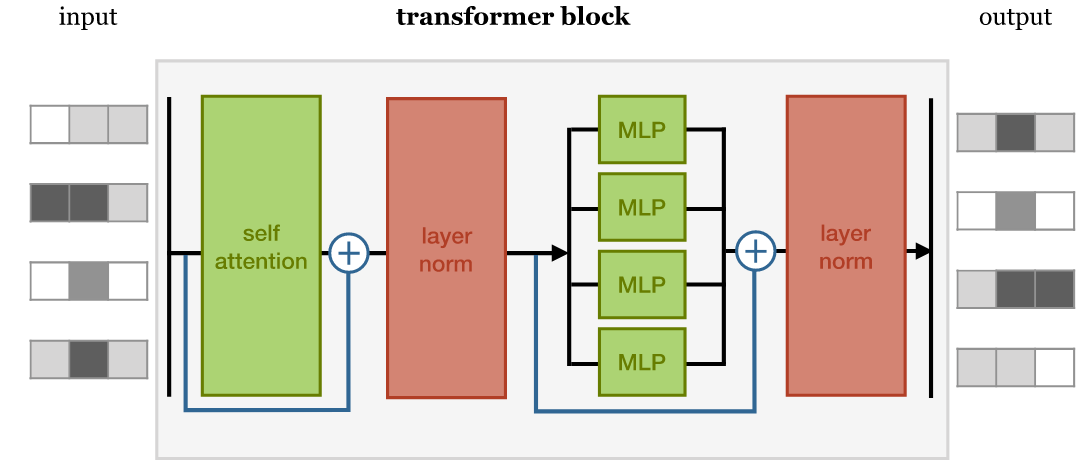

In [2]:
class TransformerBlock(nn.Module):
    def __init__(self, emb, heads, ff_hidden_mult=4, dropout=0.0):
        super().__init__()

        self.attention = SelfAttention(emb, heads=heads)

        self.norm1 = nn.LayerNorm(emb)
        self.norm2 = nn.LayerNorm(emb)

        self.ff = nn.Sequential(
            nn.Linear(emb, ff_hidden_mult * emb),
            nn.ReLU(),
            nn.Linear(ff_hidden_mult * emb, emb)
        )

        self.do = nn.Dropout(dropout)

    def forward(self, x):

        attended = self.attention(x)

        x = self.norm1(attended + x)

        x = self.do(x)

        fedforward = self.ff(x)

        x = self.norm2(fedforward + x)

        x = self.do(x)

        return x

## Inferences and Conclusion : State all the key observations and conclusion

#**Problem 2** : Sentiment Analysis using Transformers



1. Consider IMDB sentiment classification dataset or any other sentiment classification datase (Twitter, Amazon food review), consider only Positive and Negative classes.
2. Preprocess the data using text preprocessing texhniques
3. Perform the classification task using the transformer block built earlier (Construct a Classification transformer using the transformer block built above) (Below Image shows the Classification transformer)
4. Report Test accuracy and confusion matrix


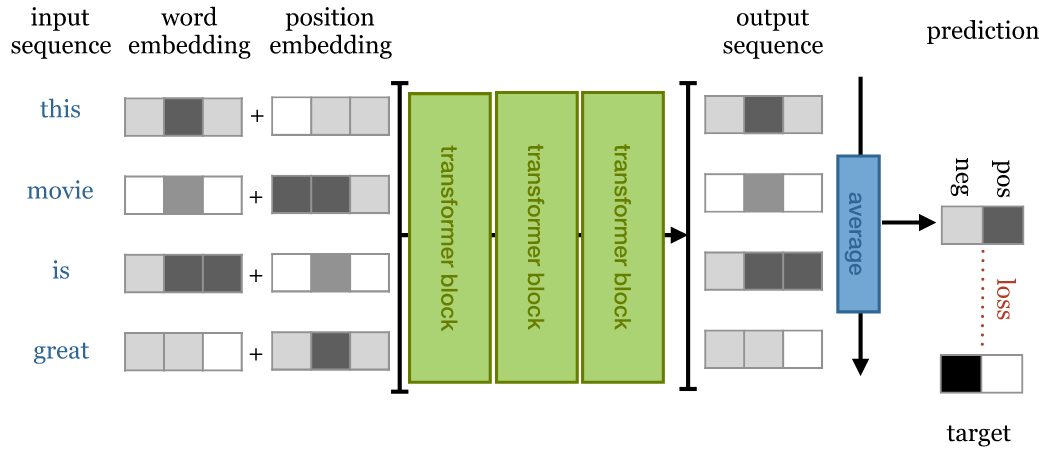

##Write down the Objectives, Hypothesis and Experimental description for the above problem


Objectives : Classifiy the Sentiments of movie based on the reviews on IMDB as positive or negatuve.

Expereimental description :

A simple sequence classification transformer is trained. The output sequence is averaged to produce a single vector representing the whole sequence. This vector is projected down to a vector with one element per class and softmaxed to produce probabilities.


## Programming : 
  Please write a program to demonstrate the same

**Use the following configurations as default, you can vary these and observe the performance** : 

1. Number of Attention Heads : 8
2. Number of Transformer Blocks : 6
3. Embedding Size : 128
4. Max Sequence Length : 512

Classification Transformer

In [3]:
import torch
from torch import nn
import torch.nn.functional as F

class CTransformer(nn.Module):
    """
    Transformer for classifying sequences
    """

    def __init__(self, emb, heads, depth, seq_length, num_tokens, num_classes, max_pool=True, dropout=0.0, wide=False):
        """
        :param emb: Embedding dimension
        :param heads: nr. of attention heads
        :param depth: Number of transformer blocks
        :param seq_length: Expected maximum sequence length
        :param num_tokens: Number of tokens (usually words) in the vocabulary
        :param num_classes: Number of classes.
        :param max_pool:If true, use global max pooling in the last layer. If false, use global
                         average pooling. 
        """
        super().__init__()

        ## Write your code here
        self.num_tokens = num_tokens
        self.token_emb = nn.Embedding(num_tokens, emb)
        self.pos_emb = nn.Embedding(seq_length, emb)

		# The sequence of transformer blocks that does all the 
		# heavy lifting
        tblocks = []
        for i in range(depth):
            tblocks.append(TransformerBlock(emb=emb, heads=heads))
        self.tblocks = nn.Sequential(*tblocks)

		# Maps the final output sequence to class logits
        self.toprobs = nn.Linear(emb, num_classes)


        ## For token and positional embeddings use nn.Embedding() 

    def forward(self, x):

        """
        :param x: A batch by sequence length integer tensor of token indices.
        :return: predicted log-probability vectors for each token based on the preceding tokens.
        """

        ## Write your code here
        """
        :param x: A (b, t) tensor of integer values representing 
                  words (in some predetermined vocabulary).
        :return: A (b, c) tensor of log-probabilities over the 
                 classes (where c is the nr. of classes).
        """

		# generate token embeddings
    #we’re stacking permutation equivariant layers, and the final global average pooling is permutation invariant,
    #so the network as a whole is also permutation invariant
        tokens = self.token_emb(x)
        b, t, k = tokens.size()

		# generate position embeddings
    #represents the position of the word in the current sentence, and add this to the word embedding
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        positions = torch.arange(t, device = device)
        positions = self.pos_emb(positions)[None, :, :].expand(b, t, k)
        
        x = tokens + positions
        x = self.tblocks(x)
        
        # Average-pool over the t dimension and project to class 
        # probabilities
        x = self.toprobs(x.mean(dim=1))
        return F.log_softmax(x, dim=1)

Importing Dataset and Text preprocessing

IMDb sentiment classification dataset: the instances are movie reviews, tokenized into sequences of words, and the classification labels are positive and negative (indicating whether the review was positive or negative about the movie).



In [4]:
import torchtext
import torch
from torchtext.legacy import data
from torchtext.legacy import datasets

TEXT = data.Field()
LABEL = data.LabelField(dtype = torch.long)
legacy_train, legacy_test = datasets.IMDB.splits(TEXT, LABEL)  # datasets here refers to torchtext.legacy.datasets

downloading aclImdb_v1.tar.gz


100%|██████████| 84.1M/84.1M [00:06<00:00, 12.1MB/s]


In [5]:
legacy_examples = legacy_train.examples
print(legacy_examples[0].text, legacy_examples[0].label)

['Small', 'SPOILERS', 'alert', '!!!<br', '/><br', '/>Good', 'movie...VERY', 'good', 'movie.', 'And', "I'm", 'surprised', 'to', 'say', 'that', 'myself,', 'because', "I'm", 'not', 'a', 'big', 'fan', 'of', 'vampires', 'and', 'the', 'sound', 'of', 'the', "director's", 'name', 'Deran', 'Serafian', 'usually', 'means', 'bad', 'news.', 'Most', 'of', 'his', 'films', 'are', 'below', 'average', 'action', 'movies', 'like', 'Death', 'Warrant', 'and', 'Gunmen.', 'This', 'was', 'one', 'of', 'his', 'first', 'films', 'and', 'maybe', 'he', 'should', 'have', 'continued', 'making', 'horror', 'movies', 'instead', 'of', 'action.', 'This', 'movie', 'really', 'fascinated', 'me.', 'Good', 'accomplishment,', 'seeing', 'no', 'famous', 'actors', 'or', 'big', 'budget', 'was', 'involved.', 'It', 'really', 'is', 'the', 'story', 'that', 'keeps', 'you', 'focused.', 'Especially', 'fans', 'of', 'the', 'original', 'Dracula', 'myth', 'will', 'be', 'satisfied.', 'Sarafian', 'lights', 'up', 'another', 'aspect', 'of', 'the',

In the above, data the default tokenizer implemented in the Field class is the built-in python split() function. So, we will do diff preprocssing on the text using data.Field

In [5]:
import re  

In [6]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
#remove stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
stop_words.add('subject')
stop_words.add('http')
def remove_stopwords(text):
    return "".join([word for word in str(text).split() if word not in stop_words])


In [8]:
def cleanup_text(texts):
    cleaned_text = []
    for text in texts:
        # remove punctuation
        text = re.sub('[^a-zA-Z0-9]', '', text)
        text = re.sub(r',','',text)
        # remove multiple spaces
        text = re.sub(r' +', ' ', text)
        # remove newline
        text = re.sub(r'\n', ' ', text)
        #remove stopwords
        text = remove_stopwords(text)

        if(len(text)!=0):
          cleaned_text.append(text)
    return cleaned_text

In [9]:
TEXT = data.Field(preprocessing=cleanup_text,tokenize=data.get_tokenizer('basic_english'),
                  init_token='<SOS>', eos_token='<EOS>', lower=True)
LABEL = data.LabelField(dtype = torch.long)
legacy_train, legacy_test = datasets.IMDB.splits(TEXT, LABEL)  # datasets here refers to torchtext.legacy.datasets

In [53]:
legacy_examples = legacy_train.examples
print(legacy_examples[0].text, legacy_examples[0].label)

['small', 'spoilers', 'alert', 'good', 'movie', 'good', 'movie', 'surprised', 'say', 'big', 'fan', 'vampires', 'sound', 'director', 'name', 'deran', 'serafian', 'usually', 'means', 'bad', 'news', 'films', 'average', 'action', 'movies', 'like', 'death', 'warrant', 'gunmen', 'one', 'first', 'films', 'maybe', 'continued', 'making', 'horror', 'movies', 'instead', 'action', 'movie', 'really', 'fascinated', 'good', 'accomplishment', 'seeing', 'famous', 'actors', 'big', 'budget', 'involved', 'really', 'story', 'keeps', 'focused', 'especially', 'fans', 'original', 'dracula', 'myth', 'satisfied', 'sarafian', 'lights', 'another', 'aspect', 'famous', 'bram', 'stoker', 'story', 'remains', 'rather', 'loyal', 'true', 'truth', 'explains', 'life', 'roemenian', 'count', 'dracula', 'scared', 'turkish', 'army', 'away', 'spearing', 'dead', 'corpses', 'front', 'castle', 'course', 'reality', 'based', 'true', 'story', 'stops', 'blood', 'drinking', 'stuff', 'invented', 'bram', 'stoker', 'movie', 'count', 'vla

In [10]:
vocab_size = 20000
TEXT.build_vocab(legacy_train, max_size=vocab_size - 2)
LABEL.build_vocab(legacy_train)

In [51]:
legacy_vocab = TEXT.vocab
print("The length of the legacy vocab is", len(legacy_vocab))
legacy_stoi = legacy_vocab.stoi
print("The index of 'example' is", legacy_stoi['example'])
legacy_itos = legacy_vocab.itos
print("The token at index 686 is", legacy_itos[686])



The length of the legacy vocab is 20002
The index of 'example' is 335
The token at index 686 is fast


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
from torchtext.legacy.data import BucketIterator
train_iter, test_iter = data.BucketIterator.splits(
    (legacy_train, legacy_test),
    batch_size=8, device = device)

In [13]:
print(f'- nr. of training examples {len(train_iter)}')
print(f'- nr. of "test" examples {len(test_iter)}')

- nr. of training examples 3125
- nr. of "test" examples 3125


In [35]:
for batch in (train_iter):
  input = batch.text.T
  label = batch.label 
  


In [ ]:
input.size()

In [26]:
input = input[:, :200]

In [ ]:
len(input[0])

Training

In [14]:
NUM_CLS = 2
vocab_size = 20000  # Only consider the top 20k words
batch_size = 32
mx = 512 # max seq length
embedding_size = 128
num_heads = 8
depth = 6
LEARNING_RATE = 1e-05
lr_warmup = 10_000
num_epochs = 2
gradient_clipping = 1


In [15]:
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
from torchtext.legacy import data, datasets, vocab
import random, tqdm, sys, math, gzip


In [16]:
# create the model
model = CTransformer(embedding_size, num_heads, depth, mx, vocab_size, NUM_CLS)
model = model.to(device)

opt = torch.optim.Adam(lr=LEARNING_RATE, params=model.parameters())
sch = torch.optim.lr_scheduler.LambdaLR(opt, lambda i: min(i / (lr_warmup / batch_size), 1.0))


In [10]:
    # training loop
    seen = 0
    for e in range(5):

        print(f'\n epoch {e}')
        model.train(True)

        for batch in tqdm.tqdm(train_iter):

            opt.zero_grad()

            input = batch.text[0]
            label = batch.label - 1
            if input.size(1) > mx:
                input = input[:, :mx]
            out = model(input)
            loss = F.nll_loss(out, label)

            loss.backward()

            # clip gradients
            # - If the total gradient vector has a length > 1, we clip it back down to 1.
            if gradient_clipping > 0.0:
                nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)

            opt.step()
            sch.step()

            seen += input.size(0)
            #[tbw].add_scalar('classification/train-loss', float(loss.item()), seen)
            #print('-- train-loss--', float(loss.item()))

        with torch.no_grad():

            model.train(False)
            tot, cor= 0.0, 0.0

            for batch in test_iter:

                input = batch.text[0]
                label = batch.label - 1

                if input.size(1) > mx:
                    input = input[:, :mx]
                out = model(input).argmax(dim=1)

                tot += float(input.size(0))
                cor += float((label == out).sum().item())

            acc = cor / tot
            print(f'-- {"test"} accuracy {acc:.3}')
            #tbw.add_scalar('classification/test-loss', float(loss.item()), e)




 epoch 0


100%|██████████| 782/782 [11:53<00:00,  1.10it/s]


-- test accuracy 0.6

 epoch 1


100%|██████████| 782/782 [11:51<00:00,  1.10it/s]


-- test accuracy 0.616

 epoch 2


100%|██████████| 782/782 [11:53<00:00,  1.10it/s]


-- test accuracy 0.661

 epoch 3


100%|██████████| 782/782 [11:51<00:00,  1.10it/s]


-- test accuracy 0.67

 epoch 4


  1%|          | 4/782 [00:04<15:33,  1.20s/it]


KeyboardInterrupt: ignored

In [ ]:
torch.save(model, '/content/drive/MyDrive/model_transformer')

In [23]:
model.train(False)
tot, cor= 0.0, 0.0
pred = []
actual = []
for batch in test_iter:

  input = batch.text[0]
  label = batch.label - 1
  actual.append(label)
  if input.size(1) > mx:
    input = input[:, :mx]
  out = model(input).argmax(dim=1)
  pred.append(out)
  #tot += float(input.size(0))
  #cor += float((label == out).sum().item())

#acc = cor / tot
#print(f'-- {"test"} accuracy {acc:.3}')


In [29]:
import numpy as np
pred_ = []
for x in pred:

  p = np.array(x.cpu())
  pred_.append(p)

In [31]:
pred_ = np.concatenate(pred_)


In [34]:
import numpy as np
actual_ = []
for x in actual:

  p = np.array(x.cpu())
  actual_.append(p)

In [35]:
actual_ = np.concatenate(actual_)


              precision    recall  f1-score   support

           0       0.75      0.49      0.59     12500
           1       0.62      0.83      0.71     12500

    accuracy                           0.66     25000
   macro avg       0.68      0.66      0.65     25000
weighted avg       0.68      0.66      0.65     25000



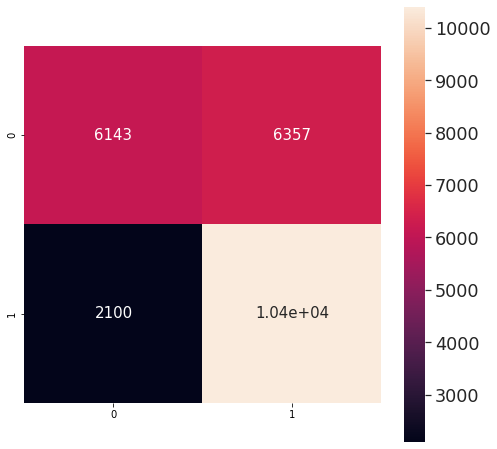

,precision,recall,f1-score,support
0,0.745238,0.49144,0.592296,12500.00000
1,0.620636,0.83200,0.710941,12500.00000
accuracy,0.661720,0.66172,0.661720,0.66172
macro avg,0.682937,0.66172,0.651619,25000.00000
weighted avg,0.682937,0.66172,0.651619,25000.00000


In [36]:
print_classification_report(pred_, actual_)

In [12]:
from sklearn.metrics import classification_report
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def print_classification_report(preds, y_test):

    # classification report
    print(classification_report(y_test, preds))
    df = pd.DataFrame(classification_report(y_test, preds,output_dict=True)).transpose()
    fig, ax = plt.subplots(figsize=(8,8)) 

    # color map
    cmap='Blues'
    # cmap = sn.diverging_palette(0, 230, 90, 60, as_cmap=True)

    cm = confusion_matrix(y_test, preds, labels=list(set(y_test)))
    # display(cm)
    df_cm = pd.DataFrame(cm, list(set(y_test)), list(set(y_test)))
    # display(df_cm)
    sn.set(font_scale=1.6)
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 15}, fmt='.4g', ax=ax, square=True)
    plt.show()
    return df
